In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dataretrieval import nwis
import requests
import json

In [3]:
# dataretrieval is a Python alternative to USGS-R's dataRetrieval package for obtaining USGS or EPA water quality data,
# streamflow data, and metadata directly from web services. Note that dataretrieval is an alternative to the R package,
# not a port, in that it reproduces the functionality of the R package but its organization and functionality often differ. 
# The Python version also expands upon its predecessor by including capability to pull data from a variety of web portals
# besides NWIS and STORET.


# services (use as service as argument for nwis.get_record())

# instantaneous values ('iv') 
# daily values ('dv')
# statistics ('stat')
# site info ('site')
# discharge peaks ('peaks')
# discharge measurements ('measurements')

In [4]:
columns = ['site_id', 'stream', 'location','lat','lon','alt']
rivers  =[['06052500', 'gallatin', 'logan', 45.88535556, -111.438286, 4086.42],
          ['06043500', 'gallatin', 'gateway', 45.4973, -111.2707083, 5167.67],
          ['06043120', 'gallatin', 'big_sky', 45.29727778, -111.2113917, 5875],
          ['06048650', 'gallatin', 'n_bozeman', 45.72566667, -111.0661944, 4625],
          ['06062500', 'tenmile_creek', 'remini', 46.5238972, -112.2566472, 4850],
          ['06063000', 'tenmile_creek', 'helena', 46.60500556, -112.0882639, 3953.21]
         ]

rivers_df = pd.DataFrame(rivers, columns=columns)

In [16]:
# get previous 12 hours worth of water data
now = datetime.today()
site = rivers_df['site_id'][2]
end = pd.to_datetime(now).strftime('%Y-%m-%d')
start = now - timedelta(days=1)
start = pd.to_datetime(start).strftime('%Y-%m-%d')



df = nwis.get_record(sites=site, service='iv', start=start, end=end)
df = df.iloc[::4,:]
df = df.reset_index()
df = df.tail(13)
df = df.rename(columns = {'00060':'discharge_cfs', '00065':'depth'})
df['pct_change_cfs'] = df.discharge_cfs.pct_change(1)
df = df[['datetime','discharge_cfs','pct_change_cfs', 'depth']]
df = df.reset_index(drop=True).drop([0])
df

,datetime,discharge_cfs,pct_change_cfs,depth
1,2022-11-29 20:00:00-07:00,165.0,-0.040698,4.61
2,2022-11-29 21:00:00-07:00,165.0,0.000000,4.61
3,2022-11-29 22:00:00-07:00,158.0,-0.042424,4.59
4,2022-11-29 23:00:00-07:00,155.0,-0.018987,4.58
5,2022-11-30 00:00:00-07:00,155.0,0.000000,4.58
6,2022-11-30 01:00:00-07:00,152.0,-0.019355,4.57
7,2022-11-30 02:00:00-07:00,152.0,0.000000,4.57
8,2022-11-30 03:00:00-07:00,152.0,0.000000,4.57
9,2022-11-30 04:00:00-07:00,155.0,0.019737,4.58
10,2022-11-30 05:00:00-07:00,158.0,0.019355,4.59


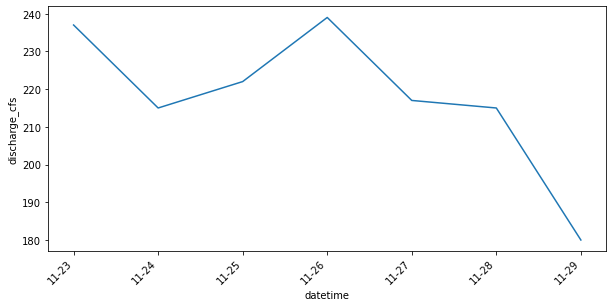

In [17]:
# get past 7 days of usgs water data
end = pd.to_datetime(now).strftime('%Y-%m-%d')
start = now - timedelta(days=8)
start = pd.to_datetime(start).strftime('%Y-%m-%d')
df = nwis.get_record(sites=site, service='dv', start=start, end=end)
df = df.rename(columns = {'00060_Mean':'discharge_cfs'})
df = df[['discharge_cfs']]
df = df.reset_index()
df['datetime'] = pd.to_datetime(df['datetime']).dt.strftime('%m-%d')
df['pct_change'] = df.discharge_cfs.pct_change(1)
df = df.drop([0])

fig = plt.figure(figsize=(10,5))
a = sns.lineplot(data=df, x='datetime', y='discharge_cfs')
fig.autofmt_xdate(rotation=45)

In [250]:
#5 Day / 3 Hour Forecast Data (https://openweathermap.org/forecast5)
key = 
lat = '45.68'
lon = '111.03'

url = f'https://api.openweathermap.org/data/2.5/forecast?lat={lat}&lon={lon}&appid={key}'
response = requests.get(url).json()
data = pd.json_normalize(response, max_level=1)
data

,cod,message,cnt,list,city.id,city.name,city.coord,city.country,city.population,city.timezone,city.sunrise,city.sunset
0,200,0,40,"[{'dt': 1669518000, 'main': {'temp': 260.27, '...",2030570,Hongor,"{'lat': 45.68, 'lon': 111.03}",MN,1000,28800,1669506655,1669539371


In [251]:
hope = data.explode('list')
newhope = hope.explode('list')
newhope

,cod,message,cnt,list,city.id,city.name,city.coord,city.country,city.population,city.timezone,city.sunrise,city.sunset
0,200,0,40,dt,2030570,Hongor,"{'lat': 45.68, 'lon': 111.03}",MN,1000,28800,1669506655,1669539371
0,200,0,40,main,2030570,Hongor,"{'lat': 45.68, 'lon': 111.03}",MN,1000,28800,1669506655,1669539371
0,200,0,40,weather,2030570,Hongor,"{'lat': 45.68, 'lon': 111.03}",MN,1000,28800,1669506655,1669539371
0,200,0,40,clouds,2030570,Hongor,"{'lat': 45.68, 'lon': 111.03}",MN,1000,28800,1669506655,1669539371
0,200,0,40,wind,2030570,Hongor,"{'lat': 45.68, 'lon': 111.03}",MN,1000,28800,1669506655,1669539371
...,...,...,...,...,...,...,...,...,...,...,...,...
0,200,0,40,wind,2030570,Hongor,"{'lat': 45.68, 'lon': 111.03}",MN,1000,28800,1669506655,1669539371
0,200,0,40,visibility,2030570,Hongor,"{'lat': 45.68, 'lon': 111.03}",MN,1000,28800,1669506655,1669539371
0,200,0,40,pop,2030570,Hongor,"{'lat': 45.68, 'lon': 111.03}",MN,1000,28800,1669506655,1669539371
0,200,0,40,sys,2030570,Hongor,"{'lat': 45.68, 'lon': 111.03}",MN,1000,28800,1669506655,1669539371
